In [181]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
mm = pd.read_csv("mmALL_073120_csv.csv")
mm = mm.query('protest == 1')
mm = mm.reset_index()

In [3]:
mm.columns # country-region-location, year, start-end, violence, amt of protesters, protesteridentity, demands, responses

Index(['index', 'id', 'country', 'ccode', 'year', 'region', 'protest',
       'protestnumber', 'startday', 'startmonth', 'startyear', 'endday',
       'endmonth', 'endyear', 'protesterviolence', 'location',
       'participants_category', 'participants', 'protesteridentity',
       'protesterdemand1', 'protesterdemand2', 'protesterdemand3',
       'protesterdemand4', 'stateresponse1', 'stateresponse2',
       'stateresponse3', 'stateresponse4', 'stateresponse5', 'stateresponse6',
       'stateresponse7', 'sources', 'notes'],
      dtype='object')

## how does state response vary?

In [4]:
mm.stateresponse1.unique()

array(['ignore', 'accomodation', 'crowd dispersal', 'arrests',
       'shootings', 'beatings', 'killings', nan], dtype=object)

In [5]:
def quantify_stateresponse(col):
    nums = []
    response_dict = {"accomodation":3, "crowd dispersal":-1,"arrests":-2,"beatings":-3,"shootings":-4,"killings":-5,"ignore":0}
    for r in col:
        if r in response_dict: nums.append(response_dict[r])
        else: nums.append(0)
    return nums

In [6]:
quantified = mm[["stateresponse1","stateresponse2","stateresponse3","stateresponse4","stateresponse5","stateresponse6","stateresponse7"]]
quantified = quantified.apply(quantify_stateresponse)
mm["stateresponse_sum"] = quantified.sum(axis=1)

### does it correlate with location?

In [7]:
mm.region.unique()

array(['North America', 'Central America', 'South America', 'Europe',
       'Africa', 'MENA', 'Asia', 'Oceania'], dtype=object)

In [8]:
len(mm.country.unique())

166

In [9]:
mm.region = [x.replace(" ", '\n') for x in mm.region.to_list()]
# mm.country = [x.replace(" ", '\n') for x in mm.country.to_list()]

Text(0.5, 1.0, '')

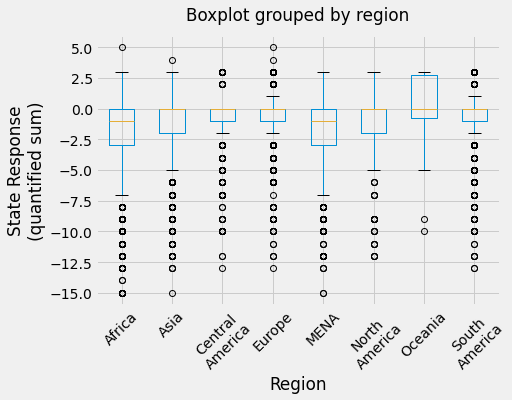

In [10]:
mm.boxplot(by = 'region', column = 'stateresponse_sum', figsize = [7,5], rot = 45)
plt.xlabel('Region')
plt.ylabel('State Response\n(quantified sum)')
plt.title('')
# plt.savefig("stateresponse_region", dpi=400, bbox_inches = 'tight')-

In [11]:
top_countries = pd.DataFrame(mm.country.value_counts()).reset_index()
top_countries = top_countries.rename(columns = {'country':'count','index':'country'}).query('count > 200')
# len(top_countries.query('count > 150'))

In [12]:
mm_topcountries = mm[mm['country'].isin(top_countries.country)]

# cr_means = {} #cr for country_response
# for c in mm.country.unique():
#     co = c
#     cr_means[co] = cr_means.get(co, mm.query('country == @co').stateresponse_sum.mean())
    
# mean_countryresponse = []
# for i in mm_topcountries.index:
#     mean_countryresponse.append(cr_means[mm_topcountries.country[i]])
# mm_topcountries['mean_countryresponse'] = mean_countryresponse

In [13]:
# mm_topcountries.sort_values('mean_countryresponse').country.unique()
# mm_topcountries = mm_topcountries.sort_values('mean_countryresponse')

Text(0.5, 1.0, '')

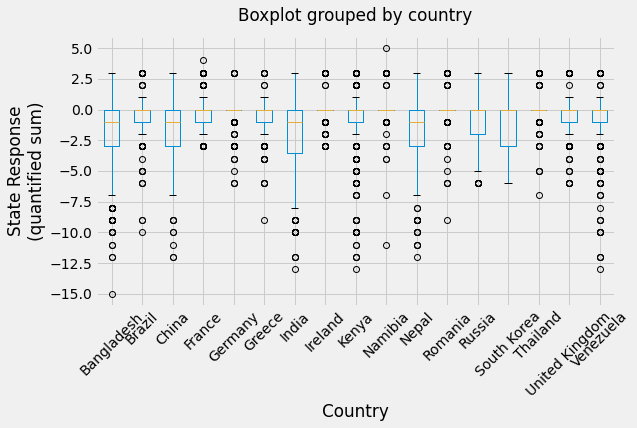

In [14]:
mm_topcountries.boxplot(by = 'country', column = 'stateresponse_sum', figsize = [9,5], rot = 45)
plt.xlabel('Country')
plt.ylabel('State Response\n(quantified sum)')
plt.title('')
# plt.savefig("stateresponse_country", dpi=400, bbox_inches = 'tight')

### by duration?

In [15]:
start = mm[['startyear', 'startmonth', 'startday']]
start = start.rename(columns = {'startyear':'year','startmonth':'month','startday':'day'})
mm['start'] = pd.to_datetime(start,yearfirst = True)

end = mm[['endyear', 'endmonth', 'endday']]
end = end.rename(columns = {'endyear':'year','endmonth':'month','endday':'day'})
mm['end'] = pd.to_datetime(end,yearfirst = True)

mm['duration'] = (mm.end - mm.start).dt.days

In [16]:
mm.duration.quantile(.999)

175.3340000000171

In [17]:
mm_regduration = mm.query('duration <= 100')
mm_longduration = mm.query('duration > 100')

In [99]:
yval = mm_regduration.query('stateresponse_sum == -10')
g = yval.query('duration > 20')
g.duration

10463    51
11081    53
13482    21
13534    43
15235    25
Name: duration, dtype: int64

In [206]:
duration_response99x_all, duration_response99y_all = [], []
duration_response99x, duration_response99y = [], []
for s in mm_regduration.stateresponse_sum.unique():
    ss = s
    yval = mm_regduration.query('stateresponse_sum == @ss')
    q99 = yval.duration.quantile(.8)
    duration_response99y.append(ss)
    duration_response99x.append(q99)
    duration_response99y_all.append(ss)
    duration_response99x_all.append(q99)
    for g in yval.query('duration > @q99').duration:
        duration_response99y_all.append(ss)
        duration_response99x_all.append(g)

linreg99x = np.array(duration_response99x).reshape(-1,1)
linreg99y = np.array(duration_response99y).reshape(-1,1)
model99 = LinearRegression().fit(linreg99x, linreg99y)
m = model99.coef_[0][0]
b = model99.intercept_[0]
model99.score(linreg99x, linreg99y)

0.3219592460706143

Text(0, 0.5, 'State Response\n(quantified sum)')

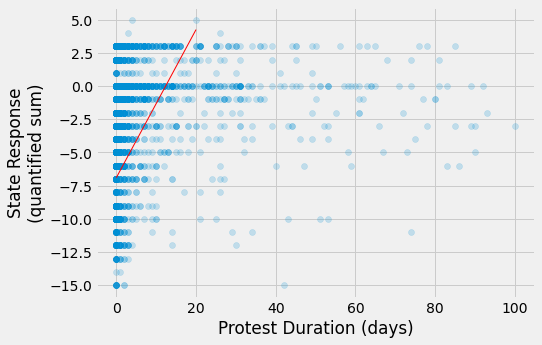

In [209]:
plt.figure(figsize = [7,5])
plt.scatter(mm_regduration.duration, mm_regduration.stateresponse_sum, alpha = .2)
# plt.scatter(duration_response99x, duration_response99y)
# plt.scatter(duration_response99x_all, duration_response99y_all, c = 'red', alpha = .1)
xlims = np.array([0,20])
plt.plot(xlims, m * xlims + b, c = 'red', lw = 1)
plt.xlabel("Protest Duration (days)")
plt.ylabel("State Response\n(quantified sum)")
# plt.savefig("stateresponse_duration", dpi=400, bbox_inches = 'tight')

Text(0, 0.5, 'State Response\n(quantified sum)')

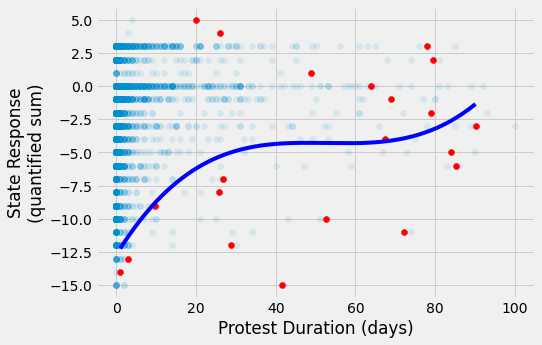

In [197]:
plt.figure(figsize = [7,5])
plt.scatter(mm_regduration.duration, mm_regduration.stateresponse_sum, alpha = .1)

X = linreg99x
y = linreg99y
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X)
lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y)
 
X_grid = np.arange(min(X),max(X),0.1)
X_grid = X_grid.reshape(len(X_grid),1) 
plt.scatter(X,y, color='red') 
 
plt.plot(X_grid, lin_reg2.predict(poly_reg.fit_transform(X_grid)),color='blue') 


plt.xlabel("Protest Duration (days)")
plt.ylabel("State Response\n(quantified sum)")
# plt.savefig("stateresponse_duration", dpi=400, bbox_inches = 'tight')

### by protester demand?

In [19]:
mm.columns

Index(['index', 'id', 'country', 'ccode', 'year', 'region', 'protest',
       'protestnumber', 'startday', 'startmonth', 'startyear', 'endday',
       'endmonth', 'endyear', 'protesterviolence', 'location',
       'participants_category', 'participants', 'protesteridentity',
       'protesterdemand1', 'protesterdemand2', 'protesterdemand3',
       'protesterdemand4', 'stateresponse1', 'stateresponse2',
       'stateresponse3', 'stateresponse4', 'stateresponse5', 'stateresponse6',
       'stateresponse7', 'sources', 'notes', 'stateresponse_sum', 'start',
       'end', 'duration'],
      dtype='object')

In [219]:
stateresponse_demand1 = mm[['protesterdemand1','stateresponse_sum']]
stateresponse_demand1.protesterdemand1 = [str(x).replace(", ",",\n") for x in stateresponse_demand1.protesterdemand1.to_list()]
stateresponse_demand1 = stateresponse_demand1.rename(columns = {'protesterdemand1' : 'protesterdemand'})

stateresponse_demand2 = mm[['protesterdemand2','stateresponse_sum']]
stateresponse_demand2.protesterdemand2 = [str(x).replace(", ",",\n") for x in stateresponse_demand2.protesterdemand2.to_list()]
stateresponse_demand2 = stateresponse_demand2.rename(columns = {'protesterdemand2' : 'protesterdemand'})

stateresponse_demand3 = mm[['protesterdemand3','stateresponse_sum']]
stateresponse_demand3.protesterdemand3 = [str(x).replace(", ",",\n") for x in stateresponse_demand3.protesterdemand3.to_list()]
stateresponse_demand3 = stateresponse_demand3.rename(columns = {'protesterdemand3' : 'protesterdemand'})

stateresponse_demand4 = mm[['protesterdemand4','stateresponse_sum']]
stateresponse_demand4.protesterdemand4 = [str(x).replace(", ",",\n") for x in stateresponse_demand4.protesterdemand4.to_list()]
stateresponse_demand4 = stateresponse_demand4.rename(columns = {'protesterdemand4' : 'protesterdemand'})

stateresponse_demand = pd.concat([stateresponse_demand1, stateresponse_demand2, stateresponse_demand3, stateresponse_demand4])
# stateresponse_demand = stateresponse_demand.protesterdemand.fillna('.')

stateresponse_demand = stateresponse_demand.query('protesterdemand != "."')
stateresponse_demand = stateresponse_demand.query('protesterdemand != "nan"')

stateresponse_demand = stateresponse_demand.query('stateresponse_sum')

C:\Users\grace\anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [220]:
stateresponse_demand#.protesterdemand.unique()

,protesterdemand,stateresponse_sum
0,"political behavior,\nprocess",0
1,"political behavior,\nprocess",0
2,"political behavior,\nprocess",0
3,land farm issue,3
4,"political behavior,\nprocess",0
...,...,...
11681,removal of politician,-1
11682,removal of politician,-1
11683,removal of politician,2
13291,police brutality,-3


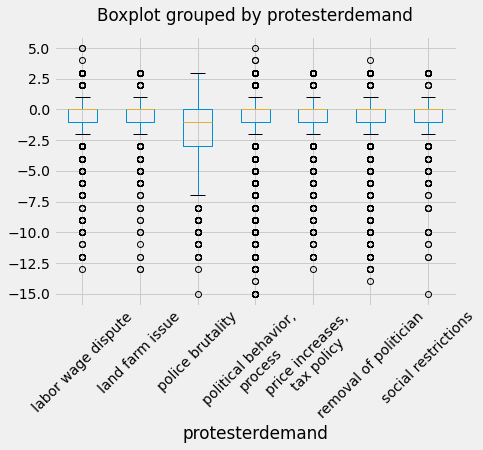

In [223]:
stateresponse_demand.boxplot(by = 'protesterdemand', column = 'stateresponse_sum', figsize = [7,5], rot = 45)
plt.title('')
plt.savefig("stateresponse_duration", dpi=400, bbox_inches = 'tight')